In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import kagglehub

In [2]:
# Uncomment the following line to download the dataset
path = kagglehub.dataset_download("idevji1/sherlock-holmes-stories")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sherlock-holmes-stories


In [3]:
# Uncomment the following line to set dataset path
path = '/kaggle/input/sherlock-holmes-stories/sherlock'

In [ ]:
# path='./sherlock'

In [4]:
# Extract all text files from the dataset path and combine into a single string
all_text = ""
for fname in os.listdir(path):
    if fname.endswith('.txt'):
        with open(os.path.join(path, fname), encoding='utf-8') as f:
            all_text += f.read() + "\n"

print(all_text[:1000])  # Print the first 1000 characters as a sample





                       THE ADVENTURE OF THE BLUE CARBUNCLE

                               Arthur Conan Doyle



     I had called upon my friend Sherlock Holmes upon the second morning
     after Christmas, with the intention of wishing him the compliments of
     the season. He was lounging upon the sofa in a purple dressing-gown,
     a pipe-rack within his reach upon the right, and a pile of crumpled
     morning papers, evidently newly studied, near at hand. Beside the
     couch was a wooden chair, and on the angle of the back hung a very
     seedy and disreputable hard-felt hat, much the worse for wear, and
     cracked in several places. A lens and a forceps lying upon the seat
     of the chair suggested that the hat had been suspended in this manner
     for the purpose of examination.

     "You are engaged," said I; "perhaps I interrupt you."

     "Not at all. I am glad to have a friend with whom I can discuss my
     results. The matter is a perfectly trivial one"--h

In [5]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### Text Preprocessing Pipeline

In [6]:
# Tokenization
tokens = [word for word in all_text.lower().split() if word not in stop_words and word.strip() != ""]
tokens = [word for word in tokens if not (word == ' ' and tokens.count(' ') > 1)]
tokens = all_text.lower().split()
word_counts = Counter(tokens)
word2idx = {word: idx+1 for idx, (word, _) in enumerate(word_counts.items())}
idx2word = {idx: word for word, idx in word2idx.items()}
total_words = len(word2idx) + 1

# Sequence creation for next-word prediction
input_sequences = []
for line in all_text.split('\n'):
    token_list = [word2idx[word] for word in line.lower().split() if word in word2idx]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
# Each n-gram sequence is padded with zeros at the beginning so that all sequences have the same length (max_seq_len).
# This ensures that the input to the model is of consistent shape.
max_seq_len = max([len(seq) for seq in input_sequences])
def pad_sequence(seq, max_len):
    return [0]*(max_len - len(seq)) + seq

input_sequences = np.array([pad_sequence(seq, max_seq_len) for seq in input_sequences])

# Features and labels
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

##### PyTorch Dataset and DataLoader

In [7]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

##### Model Architecture Design

In [10]:
# The NextWordPredictor model is a neural network designed for next-word prediction in text sequences.
# It consists of:
# - An Embedding layer: Converts word indices into dense vector representations.
# - An LSTM layer: Processes the sequence of embeddings to capture temporal dependencies and context.
# - A fully connected (Linear) layer: Maps the LSTM output to vocabulary-sized logits for next-word prediction.
# The model takes a sequence of word indices as input and outputs a probability distribution over the vocabulary for the next word.

class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextWordPredictor(total_words, 64, 100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Model Training

In [11]:
num_epochs = 60
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_train).sum().item()
        total += y_train.size(0)
    train_accuracy = correct / total
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()
            total += y_val.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/60, Train Acc: 0.1097, Val Acc: 0.1369
Epoch 2/60, Train Acc: 0.1528, Val Acc: 0.1601
Epoch 3/60, Train Acc: 0.1721, Val Acc: 0.1731
Epoch 4/60, Train Acc: 0.1873, Val Acc: 0.1840
Epoch 5/60, Train Acc: 0.2058, Val Acc: 0.1962
Epoch 6/60, Train Acc: 0.2256, Val Acc: 0.2100
Epoch 7/60, Train Acc: 0.2451, Val Acc: 0.2228
Epoch 8/60, Train Acc: 0.2635, Val Acc: 0.2350
Epoch 9/60, Train Acc: 0.2808, Val Acc: 0.2465
Epoch 10/60, Train Acc: 0.2967, Val Acc: 0.2585
Epoch 11/60, Train Acc: 0.3113, Val Acc: 0.2689
Epoch 12/60, Train Acc: 0.3251, Val Acc: 0.2783
Epoch 13/60, Train Acc: 0.3379, Val Acc: 0.2866
Epoch 14/60, Train Acc: 0.3496, Val Acc: 0.2944
Epoch 15/60, Train Acc: 0.3604, Val Acc: 0.3026
Epoch 16/60, Train Acc: 0.3707, Val Acc: 0.3111
Epoch 17/60, Train Acc: 0.3802, Val Acc: 0.3185
Epoch 18/60, Train Acc: 0.3893, Val Acc: 0.3247
Epoch 19/60, Train Acc: 0.3977, Val Acc: 0.3301
Epoch 20/60, Train Acc: 0.4053, Val Acc: 0.3366
Epoch 21/60, Train Acc: 0.4125, Val Acc: 0.3426
E

##### Prediction and Evaluation

In [12]:
def predict_next_word(model, word2idx, idx2word, text_seed, max_seq_len, device):
    model.eval()
    tokens = [word2idx.get(word, 0) for word in text_seed.lower().split()]
    tokens = pad_sequence(tokens, max_seq_len-1)
    input_tensor = torch.tensor([tokens], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted_idx = torch.argmax(output, dim=1).item()
    return idx2word.get(predicted_idx, "")

# Final validation accuracy
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

Final Validation Accuracy: 0.4380


##### Visualization and Reporting

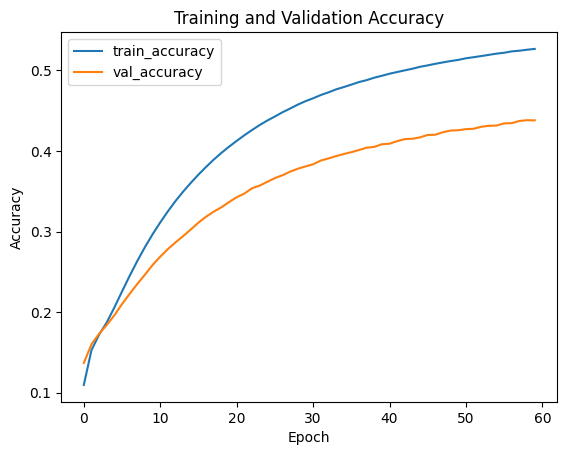

Input: 'Once upon a' -> Predicted next word: 'paper."'
Input: 'The quick brown' -> Predicted next word: 'sun'
Input: 'Deep learning is' -> Predicted next word: 'never'


In [13]:
plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Sample predictions
sample_sentences = [
    "Once upon a",
    "The quick brown",
    "Deep learning is"
]
for seed in sample_sentences:
    next_word = predict_next_word(model, word2idx, idx2word, seed, max_seq_len, device)
    print(f"Input: '{seed}' -> Predicted next word: '{next_word}'")

In [14]:
torch.save(model.state_dict(), 'next_word_predictor.pth')